In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Load and combine Syn, Ldap and NetBios data
import pandas as pd
import numpy as np
import seaborn as sns
import time

In [1]:
cd /content/drive/MyDrive/Jake-Fawcett-RNN-DDoS

[Errno 2] No such file or directory: '/content/drive/MyDrive/Jake-Fawcett-RNN-DDoS'
/content


In [ ]:
chunksize = 10 ** 5

synData = pd.DataFrame()
ldapData = pd.DataFrame()
netbiosData = pd.DataFrame()
data = pd.DataFrame()

print("Start: " + str(time.time()))
for chunk in pd.read_csv("CIC2019_CSV/Syn.csv", chunksize=chunksize, nrows=1000000):
    synData = synData.append(chunk)

data = data.append(synData)
del synData
print("Finish SYN: " + str(time.time()))

for chunk in pd.read_csv("CIC2019_CSV/LDAP.csv", chunksize=chunksize, nrows=1000000):
    ldapData = ldapData.append(chunk)

data = data.append(ldapData)
del ldapData
print("Finish LDAP: " + str(time.time()))

for chunk in pd.read_csv("CIC2019_CSV/NetBIOS.csv", chunksize=chunksize, nrows=1000000):
    netbiosData = netbiosData.append(chunk)

data = data.append(netbiosData)
del netbiosData
print("Finish NetBIOS: " + str(time.time()))

# - - - - - - - - - -
# Drop NaN and Inf values

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data = data.dropna()

# # - - - - - - - - - -
# Converting data to the right floats, removing unecessary fields
# Convert int64 and str to float 64

import ipaddress

data.replace({'Syn': 1, 'NetBIOS': 1, 'LDAP': 1, 'BENIGN': 0}, inplace=True) # replace strings
data[' Label'] = data[' Label'].astype(np.float64) # cast from int64 to float 64

data['SimillarHTTP'] = data['SimillarHTTP'].astype(bool).astype(np.float64) # Replace non-zero with 1

data.drop(['Unnamed: 0'], axis=1, inplace=True) # drop Unnamed: 0 because is just an ID
data.drop(['Flow ID'], axis=1, inplace=True) # drop Flow ID because info is in other fields (its hard to encode too)
data.drop([' Timestamp'], axis=1, inplace=True) # drop timestamp as we have them in order (its hard to encode too)

for column in data.columns:
    if data[column].dtypes == np.int64:
        data[column] = data[column].astype(np.float64)
    elif data[column].dtypes == np.float64:
        break
    else:
        for count, item in enumerate(data[column].values):
            data[column].values[count] = np.float64(int(ipaddress.IPv4Address(item)))
        data[column] = data[column].astype(np.float64)

# - - - - - - - - - -
# Scale the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 

columns = data.columns[:-1]

data[columns] = scaler.fit_transform(data[columns])

# - - - - - - - - - -
# Now we split the data, 80% training, 20% testing
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(data, test_size=0.2, random_state=1) # Splits data into training and testing

# - - - - - - - - - -
# Here we create x_train, x_test, y_train, y_test as well as oversampling/undersampling data
# due to the large difference in benign and other data
print(df_train[' Label'].value_counts())
count_class_1, count_class_0 = df_train[' Label'].value_counts()

# divide df_train
df_class_0 = df_train[df_train[' Label'] == 0]
df_class_1 = df_train[df_train[' Label'] == 1]

# Oversampling
df_class_0_oversample = df_class_0.sample(round(count_class_1 / 10), replace=True)

# Undersampling
size_to_reduce_1_to = round(count_class_1 / 10)
df_class_1_undersample = df_class_1.sample(size_to_reduce_1_to)

df_train_over_under = pd.concat([df_class_1_undersample, df_class_0_oversample], axis=0)
df_train = df_train_over_under.sample(frac=1, random_state=1)

labels = df_train.columns[:-1]
x_train = df_train[labels]
y_train = df_train[' Label']

print(" - - - - - ")
print('Random combined-sampling:')
print(y_train.value_counts())

# - - - - - - - - - -

test_count_class_1, test_count_class_0 = df_test[' Label'].value_counts()

df_test_class_0 = df_test[df_test[' Label'] == 0]
df_test_class_1 = df_test[df_test[' Label'] == 1]

df_test_class_0_oversample = df_test_class_0.sample(round(test_count_class_1), replace=True)
df_test_class_1_undersample = df_test_class_1.sample(round(test_count_class_0), replace=True)
df_test_low_rate = pd.concat([df_test_class_1_undersample, df_test_class_0_oversample], axis=0)
df_test_low_rate = df_test_low_rate.sample(frac=1, random_state=1)

print(" - - - - - ")
print("Low rate:")
print(df_test_low_rate[' Label'].value_counts())
x_test_low_rate = df_test_low_rate[labels]
y_test_low_rate = df_test_low_rate[' Label']

df_test = df_test.sample(frac=1, random_state=1)

print(" - - - - - ")
print("High rate:")
print(df_test[' Label'].value_counts())
x_test_high_rate = df_test[labels]
y_test_high_rate = df_test[' Label']

In [ ]:
# 3 attack dataset

print(x_train.shape)
x_train = x_train.values.reshape(449128, 1, 84) 

print(x_test_low_rate.shape)
x_test_low_rate = x_test_low_rate.values.reshape(568265, 1, 84) 

print(x_test_high_rate.shape)
x_test_high_rate = x_test_high_rate.values.reshape(568265, 1, 84)

print(y_train.shape)
y_train = y_train.values.reshape(449128, 1)


print(y_test_low_rate.shape)
y_test_low_rate = y_test_low_rate.values.reshape(568265, 1)

print(y_test_high_rate.shape)
y_test_high_rate = y_test_high_rate.values.reshape(568265, 1)

In [ ]:
# Parameters
batch_size 		= 20   
num_epochs 		= 100 

input_dim = 84

drop_prob_1 = 0.05
drop_prob_2 = 0.1
drop_prob_3 = 0.05

dense_size_1 = 84
dense_size_2 = 42
lstm_size = 20
dense_size_3 = 10
dense_size_4 = 5
dense_size_5 = 1

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Callback to stop when there is no loss or accuracy improvement in 3 epochs
callback_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callback_accuracy = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)

model = keras.Sequential()

# LSTM layer
model.add(layers.Dense(dense_size_1, activation="relu"))

model.add(layers.Dropout(drop_prob_1))

model.add(layers.LSTM(lstm_size, recurrent_dropout=drop_prob_2))

model.add(layers.Dense(dense_size_3, activation="relu"))

model.add(layers.Dropout(drop_prob_3))

model.add(layers.Dense(dense_size_4, activation="relu"))

model.add(layers.Dense(dense_size_5, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer="adam", metrics=["accuracy"])

In [ ]:
# Train the model using the training set
# Validation_split indicates using fraction 0.1 (10%) for validation
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.1, shuffle=True, callbacks=[callback_loss, callback_accuracy]) 

print("- - - Evaluation - - -")
print("High Rate") # Evaluate the trained model on the high rate test set!
model.evaluate(x_test_high_rate, y_test_high_rate, verbose=1)  

print("Low Rate") # Evaluate the trained model on the low rate test set!
model.evaluate(x_test_low_rate, y_test_low_rate, verbose=1)  

In [ ]:
print(model.summary())

In [ ]:
y_pred_high_rate = model.predict(x_test_high_rate)
y_pred_low_rate = model.predict(x_test_low_rate)

In [ ]:
from sklearn.metrics import r2_score

print("low rate")
r2_value = r2_score(y_test_low_rate, y_pred_low_rate.round())
print(r2_value)

print("high rate")
r2_value = r2_score(y_test_high_rate, y_pred_high_rate.round())
print(r2_value)

In [ ]:
from sklearn.metrics import confusion_matrix

print("low rate")
cf_matrix_low_test = confusion_matrix(y_test_low_rate, y_pred_low_rate.round())
print(cf_matrix_low_test)

print("high rate")
cf_matrix_high_test = confusion_matrix(y_test_high_rate, y_pred_high_rate.round())
print(cf_matrix_high_test)

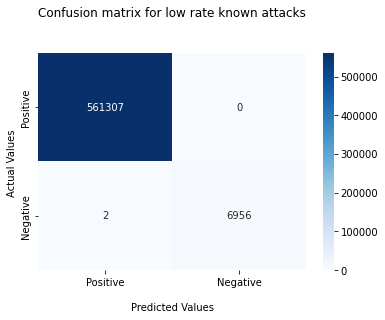

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Low rate
test_map = sns.heatmap(cf_matrix_low_test, annot=True, cmap='Blues', fmt='g')
test_map.set_title('Confusion matrix for low rate known attacks\n\n');

# High rate
# test_map = sns.heatmap(cf_matrix_high_test, annot=True, cmap='Blues', fmt='g')
# test_map.set_title('Confusion matrix for high rate known attacks\n\n');

# Config map display
test_map.set_xlabel('\nPredicted Values')
test_map.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
test_map.xaxis.set_ticklabels(['Positive','Negative'])
test_map.yaxis.set_ticklabels(['Positive','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
# Plot convergence of loss and accuracy with respect to number of epochs
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
line1 = ax1.plot(history.history["loss"])
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

fig2, ax2 = plt.subplots()
line2 = ax2.plot(history.history["accuracy"])
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")

**UDPLag simulates Zero-day attacks**

In [ ]:
# Loading and formatting the unknown (UDPLag) data in the same was as the training data

udplagData = pd.DataFrame()

for chunk in pd.read_csv("CIC2019_CSV/UDPLag.csv", chunksize=chunksize, nrows=1000000):
    udplagData = udplagData.append(chunk)

udplagData.replace([np.inf, -np.inf], np.nan, inplace=True)
udplagData = udplagData.dropna()

import ipaddress

print(udplagData[' Label'].value_counts())

udplagData.replace({'UDP': 1, 'UDPLag': 1, 'Syn': 1, 'BENIGN': 0}, inplace=True)
udplagData[' Label'] = udplagData[' Label'].astype(np.float64)

udplagData['SimillarHTTP'] = udplagData['SimillarHTTP'].astype(bool).astype(np.float64)

udplagData.drop(['Unnamed: 0'], axis=1, inplace=True)
udplagData.drop(['Flow ID'], axis=1, inplace=True)
udplagData.drop([' Timestamp'], axis=1, inplace=True)

for column in udplagData.columns:
    if udplagData[column].dtypes == np.int64:
        udplagData[column] = udplagData[column].astype(np.float64)
    elif udplagData[column].dtypes == np.float64:
        break
    else:
        for count, item in enumerate(udplagData[column].values):
            udplagData[column].values[count] = np.float64(int(ipaddress.IPv4Address(item)))
        udplagData[column] = udplagData[column].astype(np.float64)


scaler = StandardScaler() 
columns = udplagData.columns[:-1]
udplagData[columns] = scaler.fit_transform(udplagData[columns])


test_count_class_1, test_count_class_0 = udplagData[' Label'].value_counts()

udplag_data_class_0 = udplagData[udplagData[' Label'] == 0]
udplag_data_class_1 = udplagData[udplagData[' Label'] == 1]

udplag_data_class_0_oversample = udplag_data_class_0.sample(round(test_count_class_1), replace=True)
udplag_data_class_1_undersample = udplag_data_class_1.sample(round(test_count_class_0), replace=True)
udplag_data_low_rate = pd.concat([udplag_data_class_1_undersample, udplag_data_class_0_oversample], axis=0)
udplag_data_low_rate = udplag_data_low_rate.sample(frac=1, random_state=1)

print(" - - - - - ")
print("Low rate:")
print(udplag_data_low_rate[' Label'].value_counts())
x_test_low_rate_udplag = udplag_data_low_rate[labels]
y_test_low_rate_udplag = udplag_data_low_rate[' Label']

udplagData = udplagData.sample(frac=1, random_state=1)

print(" - - - - - ")
print("High rate:")
print(df_test[' Label'].value_counts())
x_test_high_rate_udplag = udplagData[labels]
y_test_high_rate_udplag = udplagData[' Label']


print(x_test_high_rate_udplag.shape)
x_test_high_rate_udplag = x_test_high_rate_udplag.values.reshape(674463, 1, 84)
print(x_test_high_rate_udplag.shape)

print(x_test_low_rate_udplag.shape)
x_test_low_rate_udplag = x_test_low_rate_udplag.values.reshape(674463, 1, 84)
print(x_test_low_rate_udplag.shape)

In [ ]:
y_pred_high_rate_udplag = model.predict(x_test_high_rate_udplag)
y_pred_low_rate_udplag = model.predict(x_test_low_rate_udplag)

In [ ]:
print("low rate")
r2_value = r2_score(y_test_low_rate_udplag, y_pred_low_rate_udplag.round())
print(r2_value)

print("high rate")
r2_value = r2_score(y_test_high_rate_udplag, y_pred_high_rate_udplag.round())
print(r2_value)

In [ ]:
print("low rate")
cf_matrix_low_udplag = confusion_matrix(y_test_low_rate_udplag, y_pred_low_rate_udplag.round())
print(cf_matrix_low_udplag)

print("high rate")
cf_matrix_high_udplag = confusion_matrix(y_test_high_rate_udplag, y_pred_high_rate_udplag.round())
print(cf_matrix_high_udplag)

In [ ]:
# Low rate
udplag_map = sns.heatmap(cf_matrix_low_udplag, annot=True, cmap='Blues', fmt='g')
udplag_map.set_title('Confusion matrix for low rate UDPLag attacks\n\n');

# High rate
# udplag_map = sns.heatmap(cf_matrix_high_udplag, annot=True, cmap='Blues', fmt='g')
# udplag_map.set_title('Confusion matrix for high rate UDPLag attacks\n\n');

# Config map display
udplag_map.set_xlabel('\nPredicted Values')
udplag_map.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
udplag_map.xaxis.set_ticklabels(['Positive','Negative'])
udplag_map.yaxis.set_ticklabels(['Positive','Negative'])

## Display the visualization of the Confusion Matrix.
plt.show()